# A/B-тестирование

## Цели исследования

В нашем распоряжении датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов. Необходимо проверить данные на соотвествие с техническим заданием и корректность проведения тестирования, исследовать и оценить результаты тестирования.

**Описание данных**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Исследование данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math as mth
import scipy.stats as stats
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

In [51]:
import plotly.io as pio

### Знакомство с данными

Первым делом необходимо познакомиться с данными таблиц и проверить на соответсвие типы данных в столбцах.

In [2]:
try:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
except:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')

In [3]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


В нашем распоряжении данные о 14 маркетинговых событиях. Данных немного, сразу можно заметить отсутсвие пропусков и дубликатов. В столбцах с датами необходимо скорректировать тип данных.

In [5]:
try:
    new_users = pd.read_csv('final_ab_new_users.csv')
except:
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv')

In [6]:
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [7]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


Перед нами таблица с данными о новых пользователях в тестируемом периоде - всего их получается 61733 человека (возможны дубликаты). Пропусков в данных не обнаружено. У столбца с датой снова несоответсвие в типе данных.

In [8]:
try:
    events = pd.read_csv('final_ab_events.csv')
except:
    events = pd.read_csv('/datasets/final_ab_events.csv')

In [9]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [10]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


В таблице с событиями (действиями) пользователей содержится 440317 записей, т.е. примерно по 7 событий на человека. В столбце с деталями по событиям очень много пропусков, однако эти данные не влияют на исследование. Столбец с датой необходимо привести к корректному типу.

In [11]:
try:
    ab_participants = pd.read_csv('final_ab_participants.csv')
except:
    ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [12]:
ab_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


In [13]:
ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


И последняя таблица содержит данные о распределении пользователей по тестам и группам внутри тестов. Пропусков в данных нет. Все типы в столбцах соответсвуют данным.

### Предобработка данных

После знакомства с данными мы выявили рассхождение в типе данных в столбцах с датами. Также необходимо проверить наличие дубликатов в последних трех таблицах.

In [14]:
# меняем тип данных на дату
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

new_users['first_date'] = pd.to_datetime(new_users['first_date'])

events['event_dt'] = pd.to_datetime(events['event_dt'])

In [15]:
# проверим наличие явных дубликатов в таблицах
print('В таблице с пользователями', new_users.duplicated().sum(), 'дубликатов.')
print('В таблице с событиями', events.duplicated().sum(), 'дубликатов.')
print('В таблице с участниками тестирования', ab_participants.duplicated().sum(), 'дубликатов.')

В таблице с пользователями 0 дубликатов.
В таблице с событиями 0 дубликатов.
В таблице с участниками тестирования 0 дубликатов.


Типы столбцов приведены в порядок. Явных дубликатов в данных нет.

Проверим, могут ли повторяться id новых пользователей, если они используют разные девайсы для входа, или каждое устройство подразумевает уникального пользователя.

In [16]:
new_users['user_id'].nunique()

61733

Число уникальных id  совпадает с числом строк в таблице, значит все пользователи таблицы уникальны.

Изучим пропуски в данных. Единственная таблица с пропусками - данные о действиях пользователей. Посмотрим у каких событий есть детали и подумаем нужно ли как-то обработать пропуски.

In [17]:
events.groupby('event_name').agg({'details': 'count'})

,details
event_name,
login,0
product_cart,0
product_page,0
purchase,62740


In [18]:
events.query('event_name == "purchase" & details.isna()')

,user_id,event_dt,event_name,details


Получается, что дополнительная информация есть только по действию покупка, причем для всех. Следовательно, какой-либо обработки данный столбец не требует.

## Проверка корректности тестирования

Чтобы убедиться, что АБ тест корректно отработал, необходимо:
 - сверить соответсвие техническим требованиям
 - удостовериться, что время проведения тестирования не пересекается с маркетинговыми событиями (обычно такие события повышают спрос на покупки, что может исказить результаты теста)
 - проверить, что каждый участник тестирования относится только к одному тестированию и только к одной группе внутри тестирования

Первый пункт технического требования - это название тестирование. Проверим, что данные о `recommender_system_test` занесены в нашу таблицу.

In [19]:
test = ab_participants.query('ab_test == "recommender_system_test"')
test

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


Данные о нашем тесте имеются - целых 6701 запись. Убедимся, что все пользователи в тестировании - новые.

In [20]:
test[test['user_id'].isin(new_users['user_id'])]

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


Записей столько же, значит все пользователи новые.

Посмотрим сколько пользователей совершали событие, чтобы понять реальное количество пользователей в тесте.

In [21]:
test[test['user_id'].isin(events['user_id'])]

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


Всего лишь 3675 пользователей совершили хотя бы одно событие за время теста. Данных намного меньше, чем ожидалось. Далее будем проверять данные по всеми пользователями из теста, даже если они не совершили действие.

Следующее, что необходимо проверить, это даты. Убедимся, что даты начала и конца набора новых пользователей и самого тестирования соответсвуют ТЗ, а также, что нет пересечения с маркетинговыми событиями.

In [22]:
print('Первый пользователь из теста зарегистрировался',
      new_users[new_users['user_id'].isin(test['user_id'])]['first_date'].min(),
      'числа, а последний пользователь зарегистриовался',
      new_users[new_users['user_id'].isin(test['user_id'])]['first_date'].max(), 'числа.')
print('Первое действие пользователя из тестовой группы было совершенно',
      events[events['user_id'].isin(test['user_id'])]['event_dt'].min(),
      'а последнее действие -',
      events[events['user_id'].isin(test['user_id'])]['event_dt'].max())

Первый пользователь из теста зарегистрировался 2020-12-07 00:00:00 числа, а последний пользователь зарегистриовался 2020-12-21 00:00:00 числа.
Первое действие пользователя из тестовой группы было совершенно 2020-12-07 00:05:57 а последнее действие - 2020-12-30 12:42:57


Дата запуска тестирования и дата остановки набора новых пользователей соответсвуют ТЗ. Дата остановки тестирования не соответсвует ТЗ - последнее действие пользователя из нашего тестирования приходится на 30.12, а не 04.01.

In [23]:
first_date = events[events['user_id'].isin(test['user_id'])]['event_dt'].min()
last_date = events[events['user_id'].isin(test['user_id'])]['event_dt'].max()

for i in range(len(marketing_events)):
    if ((marketing_events.loc[i, 'start_dt'] >= first_date and marketing_events.loc[i, 'start_dt'] <= last_date) or
        (marketing_events.loc[i, 'start_dt'] <= first_date and marketing_events.loc[i, 'finish_dt'] >= last_date) or
        (marketing_events.loc[i, 'finish_dt'] >= first_date and marketing_events.loc[i, 'finish_dt'] <= last_date) or
        (marketing_events.loc[i, 'start_dt'] >= first_date and marketing_events.loc[i, 'finish_dt'] <= last_date)):
        print(marketing_events.loc[i, 'name'], 'проводится в', marketing_events.loc[i, 'regions'],
              'регионах и пересекается по времени с тестированием')

Christmas&New Year Promo проводится в EU, N.America регионах и пересекается по времени с тестированием
CIS New Year Gift Lottery проводится в CIS регионах и пересекается по времени с тестированием


Пересечения с маркетинговыми событиями присутсвует, причем с двумя. Чтобы оценить влияние событий необходимо рассмотреть динамику взаимодействия пользователей. Если сильных скачков и изменений не обнаружится, на такое пересечение можно будет закрыть глаза.

In [24]:
users = test['user_id']
events['day'] = events['event_dt'].dt.normalize()

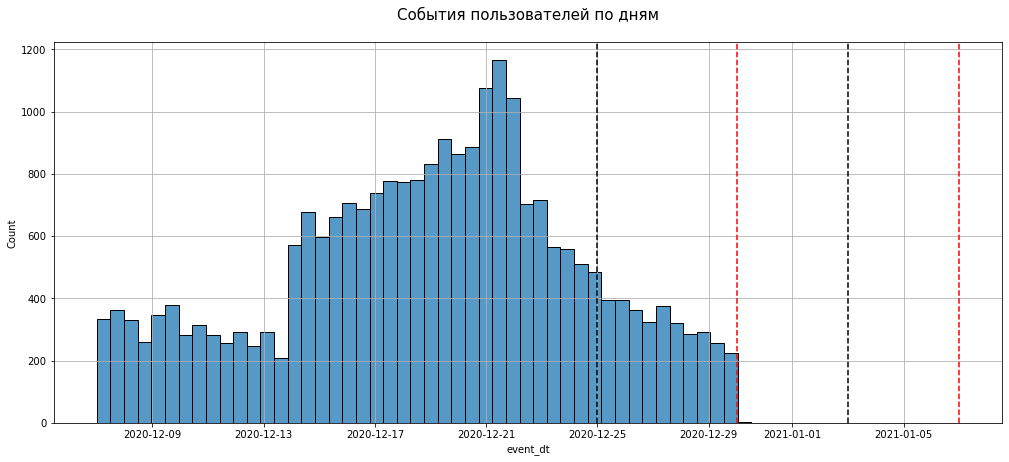

In [25]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.grid()
ax.set_title('События пользователей по дням' + '\n', fontsize = 15)
sns.histplot(data=events.query('user_id.isin(@users)'), x='event_dt')
plt.axvline(x=marketing_events.query('name == "Christmas&New Year Promo"')['start_dt'], color='black', linestyle='--')
plt.axvline(x=marketing_events.query('name == "Christmas&New Year Promo"')['finish_dt'], color='black', linestyle='--')
plt.axvline(x=marketing_events.query('name == "CIS New Year Gift Lottery"')['start_dt'], color='red', linestyle='--')
plt.axvline(x=marketing_events.query('name == "CIS New Year Gift Lottery"')['finish_dt'], color='red', linestyle='--')
plt.show();

Из графика видно, что число событий лишь уменьшилось во время Рожденственско-Новогоднего события, а на момент Новогодней лотерии вообще событий почти нет. Т.е. маркетинговые события не оказали влияния на действия пользователей.

Посмотрим, как распределены пользователи по группам и есть ли пересечения с другими тестами.

In [26]:
# проверим наличие пользователей в разных тестах
doubles = ab_participants.groupby('user_id', as_index=False).agg({'ab_test': 'nunique'}).query('ab_test > 1')['user_id']
doubles.count()

1602

В обоих тестах участвует 1602 пользователя. Для нас важно, чтобы пользователи эксперементальной группы другого теста не попали в наш тест, потому что тогда будет сложно определить, что именно повлияло на пользователей. Уберем тех, кто находится в параллельном тесте в группе B.

In [27]:
bad_id = ab_participants.query('ab_test != "recommender_system_test" & user_id.isin(@doubles) & group == "B"')['user_id']
test = test.query('~ user_id.isin(@bad_id)')

In [28]:
# посмотрим как рапределены пользователи в нашем тесте по группам
test.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
A,3385
B,2533


In [29]:
test.groupby('user_id').agg({'group': 'nunique'}).query('group > 1').count()

group    0
dtype: int64

В группе А значительный перевес в количестве участников.
Участники в группах не пересекаются.

Проверим, чтобы все пользователи были из Европы, а также составляли 15% от всех новых пользователей Европы.

In [30]:
new_users[new_users['user_id'].isin(test['user_id'])]['region'].value_counts()

EU           5568
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

In [31]:
test.merge(new_users[['user_id', 'region']], on='user_id').groupby(['group', 'region']).agg({'user_id':'nunique'})

user_id
group region            
A     APAC            37
      CIS             25
      EU            3195
      N.America      128
B     APAC            35
      CIS             30
      EU            2373
      N.America       95

В нашем тестировании участвуют представители сразу нескольких регионов, однако между группами они разделены достаточно равномерно (кроме Европейцев), поэтому можно их оставить.

In [32]:
users = test['user_id']
new_users.query('user_id.isin(@users) & region == "EU"')['user_id'].count() \
/ new_users.query('region == "EU"')['user_id'].count() * 100 

12.033715150205317

Европейские пользователи в нашем тесте составляют 12% от всех новых Европейских пользователей. Пункт тз не выполнен. Также после удаления межтестовых пользователей в тесте осталось менее 6000 участников.

Чтобы проверить последний пункт ТЗ необходимо расчитать базовую конверсию на каждом этапе в обеих группах. Этот пункт мы проверим во время исследовательского анализа.

Посчитаем, сколько в среднем уходит времени у пользователей на то, чтобы совершить первое действие после регистрации (*delta*), и уберем тех, кто зарегистрировался меньше чем за *delta* дней до завершения теста. А также уберем действия пользователей после 14 дней со дня регистрации, потому что нас интерисуют улучшения только за 2 недели.

In [33]:
users = test['user_id']
test_events = events.query('user_id.isin(@users)').merge(new_users[['user_id', 'first_date']], how='left', on='user_id')

In [34]:
df = (
    test_events
    .groupby('user_id', as_index=False)
    .agg({'day': min, 'first_date': 'first'})
)
df['delta'] = df['day'] - df['first_date']
df['delta'].median()

Timedelta('0 days 00:00:00')

Пользователи совершают свое первое действие в течении суток. Все остаются. Осталось убрать действия по истечении 2 недель.

In [35]:
test_events = test_events[events['day'] - test_events['first_date'] <= '14 days']

C:\Users\USER\AppData\Local\Temp\ipykernel_9660\1764176043.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_events = test_events[events['day'] - test_events['first_date'] <= '14 days']


In [36]:
test.shape

(5918, 3)

**Выводы:**
- данные не соответсвуют требованиям ТЗ в полной мере:

  - дата остановки теста, судя по дате последнего действия пользователя, 30 декабря
  - среди пользователей есть представители других регионов, однако между группами они распределены равномерно, поэтому не должны оказать сильного влияния на результаты теста
  - задействовано менее 15% новых пользователей из региона Европа (по факту 12%)
  - количество пользователей в тесте чуть менее 6000, однако тех, кто совершил хотя бы одно действие, не менее 4000
  
  
- время проведения теста пересекается с двумя маркетинговыми событиями, однако увеличения динамики событий не наблюдается


- в тесте задействованы пользователи, также участвующие в конкурирующем тестировании (пользователи конкуриющей тестовой группы были удалены); между группами пользователи распределены не равномерно, пересечений нет

О наличии улучшения каждой метрики не менее,чем на 10% скажем после исследовательского анализа.

## Исследовательский анализ

In [37]:
data = test_events.merge(test[['user_id', 'group']], how='left', on='user_id')
data

,user_id,event_dt,event_name,details,day,first_date,group
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,A
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,2020-12-07,A
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,2020-12-07,B
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,2020-12-07,A
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,2020-12-07,B
...,...,...,...,...,...,...,...
21837,E5589EAE02ACD150,2020-12-29 22:17:08,login,NaN,2020-12-29,2020-12-20,A
21838,D21F0D4FDCD82DB2,2020-12-29 02:17:00,login,NaN,2020-12-29,2020-12-20,A
21839,553BAE96C6EB6240,2020-12-29 14:09:14,login,NaN,2020-12-29,2020-12-20,A
21840,DD4352CDCF8C3D57,2020-12-30 12:42:56,login,NaN,2020-12-30,2020-12-07,B


Посмотрим, как много событий в среднем совершает каждый пользователь в разных группах.

In [38]:
events_by_group = data.groupby('group').agg({'user_id':['count', 'nunique']})
events_by_group.columns = ['ttl_events', 'ttl_users']
events_by_group['avg_per_psn'] = events_by_group['ttl_events'] / events_by_group['ttl_users']
events_by_group

,ttl_events,ttl_users,avg_per_psn
group,,,
A,17149,2422,7.080512
B,4693,822,5.709246


В среднем в контрольной группе пользователи совершают больше событий, чем в тестовой, однако разница небольшая. Можно считать, что количество событий на пользователей одинаково распределены в выборках.

Посмотрим, как события распределны по дням в разных группах.

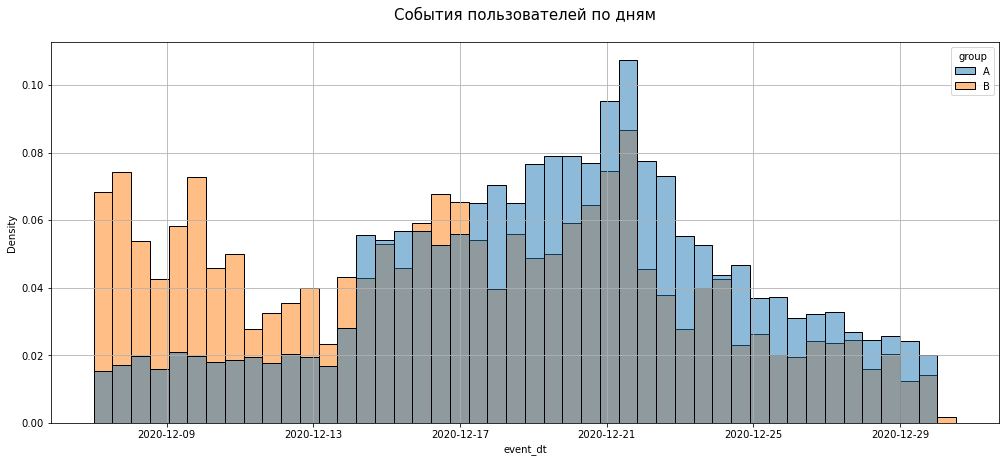

In [39]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.grid()
ax.set_title('События пользователей по дням' + '\n', fontsize = 15)
sns.histplot(data=data, x='event_dt', hue='group', stat="density", common_norm=False)
plt.show();

На графике видно, что в контрольной группе в перую неделю было очень мало событий. Основное количество событий пришлось на 2 и начало 3 недели. К концу 3 недели показатели вернулись к показателям первой недели.

В тестовой же группе первые две недели показатели были почти стабильны, за исключением спада на 12-13 декабря. На третьей недели также, как и у контрольной был заметен спад активности, показатели опустились даже ниже, чем в 12-13 числа.

In [40]:
# Посмотрим из каких событий состоит воронка
data['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Получили следующие типы действий:
- `login` - вход в систем
- `product_page` - переход на страницу продукта
- `purchase` - оплата покупки
- `product_cart` - переход в корзину

Логично предположить, что первое действие - это вход в систему (аккаунт), затем просмотр продукта, переход в корзину, а последнее - это оплата покупки.

Построим воронку событий, посотрим, как меняется конверсия на разных этапах и проверим наличие улучшения метрик на 10%.

In [41]:
uniq_users_per_event = (
    data
    .groupby(['event_name', 'group'], as_index=False)
    .agg({'user_id': 'nunique'})
    .sort_values(by='event_name')
    .iloc[[0, 1, 4, 5, 2, 3, 6, 7]]
    .reset_index(drop=True)
)
uniq_users_per_event

,event_name,group,user_id
0,login,A,2422
1,login,B,822
2,product_page,A,1571
3,product_page,B,459
4,product_cart,A,728
5,product_cart,B,225
6,purchase,A,773
7,purchase,B,226


In [42]:
share = [round(uniq_users_per_event['user_id'][i] / uniq_users_per_event['user_id'].iloc[i - 2] * 100, 2)
         for i in range(len(uniq_users_per_event['user_id']))]
share[0] = 100
share[1] = 100

ttl_share = [round(uniq_users_per_event['user_id'][i] / uniq_users_per_event['user_id'][0] * 100, 2) if i%2 == 0 else \
             round(uniq_users_per_event['user_id'][i] / uniq_users_per_event['user_id'][1] * 100, 2)
         for i in range(len(uniq_users_per_event['user_id']))]

uniq_users_per_event['share_per_step'] = share
uniq_users_per_event['ttl_share'] = ttl_share
uniq_users_per_event

,event_name,group,user_id,share_per_step,ttl_share
0,login,A,2422,100.00,100.00
1,login,B,822,100.00,100.00
2,product_page,A,1571,64.86,64.86
3,product_page,B,459,55.84,55.84
4,product_cart,A,728,46.34,30.06
5,product_cart,B,225,49.02,27.37
6,purchase,A,773,106.18,31.92
7,purchase,B,226,100.44,27.49


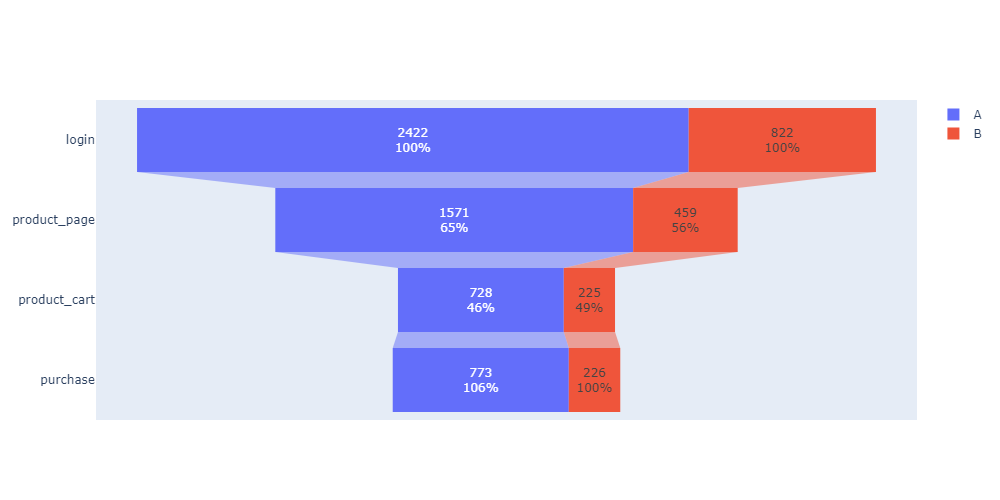

In [52]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = uniq_users_per_event.query('group == "A"')['event_name'],
    x = uniq_users_per_event.query('group == "A"')['user_id'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = uniq_users_per_event.query('group == "B"')['event_name'],
    x = uniq_users_per_event.query('group == "B"')['user_id'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.show(renderer="png", width=1000, height=500)

Почти на всех этапах конверсия в группе В хуже, чем в А. На этапе `product_cart` есть небольшое улучшение по сравнению с группой А, однако улучшения метрики на 10% не наблюдается нигде. Если рассматривать процент пользователей, которые дошли до некоторого этапа относительно первого, то по всем шагам группа В проигрывает.

Интересно также заметить, что до этапа покупка доходит больше пользователей, чем предыдущего этапа - просмотр корзины. Вероятно, есть возможность купить товар сразу со страницы продукта.

Прежде чем приступать к тестированию необходимо определить минимальный размер групп и длительность теста на основе имеющихся данных: базовая конверсия, относительное изменение конверсии, среднее количество посещений в день и какой процент пользователей будет задейстован в тесте.

Также важно при возможности проводить А/А тестирование, чтобы проверить корректность распределения пользователей по группам. Важно проводить тестирования в обычное, не предпраздничное время / не во время маркетингово события, чтобы данные не искажались. А также с осторожностью проводить несколько тестоводновременно, чтобы не получилась ситуация, когда пользователи сразу увидели все изменения.

В нашем случае получается, что наша базовая конверсия - 32%, относительное изменение конверсии - 10%, тогда используя калькулятор, найдем, что размеры каждой группы должны составлять хотя бы 3360. В нашем же тесте 5918 пользователей, из еоторых действия совершали только 2422 и 822 пользователя в группах А и В соответсвенно. То есть для корректного анализа у нас недостаточно данных.

## Оценка результатов A/B-тестирования

Чтобы оценить результаты тестирования проверим несколько гипотез. Однако уже из воронки видно, что улучшений в группе В относително группы А нет.

Проверим гипотезу, о том что конверсия в покупателей у группы А и В одинаковые:
 - $H_0$: доли уникальных посетителей, побывавших на некотором этапе воронки, одинаковы.
 - $H_1$: между долями уникальных посетителей, побывавших на некотором этапе воронки, есть значимая разница.

In [44]:
# составим сводную таблицу - воронка для каждой группы эксперимента

voronka = (
    data
    .pivot_table(index='group', columns='event_name', values='user_id',
                 aggfunc='nunique', margins=True)
)

voronka = voronka[['login', 'product_page', 'product_cart', 'purchase', 'All']]

voronka

event_name,login,product_page,product_cart,purchase,All
group,,,,,
A,2422,1571,728,773,2422
B,822,459,225,226,822
All,3244,2030,953,999,3244


In [45]:
# выберем уровень значимости
alpha = 0.05

In [46]:
# напишем функцию, которая проверяет равенство долей групп
# где параметр event принимает значения события в воронке до которого дошли пользователи
# product_page, product_cart, purchase, All

def is_there_diff(event):
    last_step = np.array([voronka.loc['A', event],
                          voronka.loc['B', event]])
    
    first_step = np.array([voronka.loc['A', 'All'], voronka.loc['B', 'All']])
    
    p1 = last_step[0] / first_step[0]
    p2 = last_step[1] / first_step[1]
    p_combined = (last_step[0] + last_step[1]) / (first_step[0] + first_step[1])
    
    z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1 / first_step[0] + 1 / first_step[1]))
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями уникальных пользователей, побывавших на этапе',
              event, 'есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей, побывавших на этапе', event, 'разными')

In [47]:
# напишем функцию, которая будет сообщать нам число и долю пользователей, дошедших до определенного шага воронки
def func(group, event):
    print(f'''В {group} группе до этапа {event} дошло {voronka.loc[group, event]} пользователей.
Это составляет {round(voronka.loc[group, event] / voronka.loc[group, 'All'], 2)} от общего числа пользователей группы.''')
    print()

In [48]:
func('A', 'product_page')
func('B', 'product_page')
is_there_diff('product_page')

В A группе до этапа product_page дошло 1571 пользователей.
Это составляет 0.65 от общего числа пользователей группы.

В B группе до этапа product_page дошло 459 пользователей.
Это составляет 0.56 от общего числа пользователей группы.

p-значение:  3.8415005565450855e-06
Отвергаем нулевую гипотезу: между долями уникальных пользователей, побывавших на этапе product_page есть значимая разница


Между долями дошедших пользователей до этапа просмотр страницы продукта есть значимая разница. Таким образом, данный этап группа В провалила.

In [49]:
func('A', 'product_cart')
func('B', 'product_cart')
is_there_diff('product_cart')

В A группе до этапа product_cart дошло 728 пользователей.
Это составляет 0.3 от общего числа пользователей группы.

В B группе до этапа product_cart дошло 225 пользователей.
Это составляет 0.27 от общего числа пользователей группы.

p-значение:  0.14412076974264498
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли уникальных пользователей, побывавших на этапе product_cart разными


Между долями дошедших пользователей до этапа просмотр корзины значимой разницы нет. Таким образом, данный показатель группы В не ухудшился.

In [50]:
func('A', 'purchase')
func('B', 'purchase')
is_there_diff('purchase')

В A группе до этапа purchase дошло 773 пользователей.
Это составляет 0.32 от общего числа пользователей группы.

В B группе до этапа purchase дошло 226 пользователей.
Это составляет 0.27 от общего числа пользователей группы.

p-значение:  0.01764968717521609
Отвергаем нулевую гипотезу: между долями уникальных пользователей, побывавших на этапе purchase есть значимая разница


И последний этап также показал значимую разницу в пользу группы А. 

## Выводы
Опишите выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделайте общее заключение о корректности проведения теста.

Подведем итоги исследовательского анализа и оценки A/B-тестирования.
- В среднем в контрольной группе пользователи совершают больше событий - 7, чем в тестовой - 5.7, однако разница небольшая. Можно считать, что количество событий на пользователей одинаково распределены в выборках.


- События пользователей по дням распределены по-разному в группах.
  - В контрольной группе в перую неделю было очень мало событий. Основное количество событий пришлось на 2 и начало 3 недели. К концу 3 недели показатели вернулись к показателям первой недели.
  - В тестовой же группе первые две недели показатели были почти стабильны, за исключением спада на 12-13 декабря. На третьей недели также, как и у контрольной был заметен спад активности, показатели опустились даже ниже, чем в 12-13 числа.
  
  
- При построении воронки видно, что почти на всех этапах конверсия в группе В хуже, чем в А. На этапе `product_cart` есть небольшое улучшение по сравнению с группой А, однако улучшения метрики на 10% не наблюдается нигде. Если рассматривать процент пользователей, которые дошли до некоторого этапа относительно первого, то по всем шагам группа В проигрывает.


- Интересно также заметить, что до этапа покупка доходит больше пользователей, чем предыдущего этапа - просмотр корзины. Вероятно, есть возможность купить товар сразу со страницы продукта.


- При оценки результатов тесто было выявлено, что на втором и на последнем этапах разницца между долями дошедших пользователей имеет статистическую значимость, причем не в пользу группы В. На этапе `product_cart` - переход в корзину - статистической разницы между долями выявлено не было.

Таким образом, тестовая группа В не то что не выявила улучшения в показателях метрик, но даже их ухудшила. Также важно отметить, что данные для тестирования были подготовлены плохо: количество активных пользователей в обеих группах не дотягивает до необходимого минимума чтобы заметить улучшения в конверсии на 10%, в данных имеется значительный всплеск во вторую неделю, как в количестве пользователей, так и в количестве их действий, что также говорит о неудачно выбранном для тестирования периоде (скорее всего всплеск вызван единичными потребностями пользователей перед праздниками).